# 1. Assignment 2

Tom de Wildt (`2068292`)

**Import packages**

In [1]:
from collections import Counter
import math
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

from FuzzyTM import FLSA, FLSA_W, FLSA_V, FLSA_E
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

import matplotlib.colors as mcols
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Settings**

In [2]:
# Folders
DATASET_FOLDER = "../data/"

# Datasets
NEWS_DATASET_FILE = "us_equities_news.csv"

# Settings
RANDOM_SEED = 42

# Other
TEXT_START = "\033[1m"
TEXT_END = "\033[0m"

In [3]:
np.random.seed(RANDOM_SEED)
tqdm.pandas()

## 1.1 Import data

In [4]:
%%time
df_us_equities_news = pd.read_csv(DATASET_FOLDER + NEWS_DATASET_FILE)

CPU times: user 5.31 s, sys: 401 ms, total: 5.71 s
Wall time: 5.76 s


## 1.2 Preprocess data

### 1.2.1 Prepare data

**Rename columns**

In [5]:
df_us_equities_news = df_us_equities_news.rename(columns={"release_date": "date"})

**Set data types**

In [6]:
df_us_equities_news["id"] = df_us_equities_news["id"].astype(int)
df_us_equities_news["ticker"] = df_us_equities_news["ticker"].astype("category")
df_us_equities_news["title"] = df_us_equities_news["title"].astype(str)
df_us_equities_news["category"] = df_us_equities_news["category"].astype("category")
df_us_equities_news["content"] = df_us_equities_news["content"].astype(str)
df_us_equities_news["date"] = pd.to_datetime(df_us_equities_news["date"])
df_us_equities_news["provider"] = df_us_equities_news["provider"].astype("category")
df_us_equities_news["url"] = df_us_equities_news["url"].astype(str)
df_us_equities_news["article_id"] = df_us_equities_news["article_id"].astype(int)

### 1.2.2 Subset data

In [7]:
df_us_equities_news = df_us_equities_news[df_us_equities_news["title"].str.contains("Apple")]

### 1.2.3 Clean data

**Remove duplicate rows**

In [8]:
print(f"Rows (Before): {df_us_equities_news.shape[0]}")
df_us_equities_news = df_us_equities_news.drop_duplicates(subset=["content"])
print(f"Rows (After): {df_us_equities_news.shape[0]}")

Rows (Before): 5117
Rows (After): 5109


**Remove null values**

In [9]:
print(f"Rows (Before): {df_us_equities_news.shape[0]}")
df_us_equities_news = df_us_equities_news[
    (df_us_equities_news["title"] != "nan")
    & (df_us_equities_news["content"] != "nan")
]
print(f"Rows (After): {df_us_equities_news.shape[0]}")

Rows (Before): 5109
Rows (After): 5109


**Remove unused columns**

In [10]:
df_us_equities_news = df_us_equities_news.drop(columns=["id", "url", "article_id"])

**Reset index**

In [11]:
df_us_equities_news = df_us_equities_news.reset_index(drop=True)

**Sort rows**

In [12]:
df_us_equities_news = df_us_equities_news.sort_values("date")

## 1.3 Explore data

### 1.3.1 Inspect rows

In [13]:
df_us_equities_news.head(10)

,ticker,title,category,content,date,provider
5000,MSFT,COLUMN What Apple loses without Steve Eric Au...,news,Eric Auchard is a Reuters columnist The op...,2009-01-15,Reuters
4999,MSFT,UPDATE 2 Microsoft to open own stores take on...,news,Adds details on stores background on retaili...,2009-02-12,Reuters
5065,DELL,UPDATE 5 Apple halves iPhone to 99 trims Mac...,news,Apple cuts entry iPhone price to 99 reveal...,2009-06-08,Reuters
5096,MMM,US STOCKS McDonald s Apple drag down Wall Street,news,McDonald s shares fall after May sales\n A...,2009-06-08,Reuters
5055,NYT,CHRONOLOGY Key dates in health saga of Apple s...,news,June 30 Reuters Apple Inc Co founder and ...,2009-06-29,Reuters
5053,SPGI,US STOCKS Wall St climbs on Caterpillar Apple...,news,Caterpillar sees tough Q3 but stock lifts D...,2009-07-21,Reuters
785,KO,US STOCKS Apple Starbucks lift Nasdaq Dow S...,news,Apple Starbucks lift Nasdaq on solid profit...,2009-07-22,Reuters
786,KO,US STOCKS Nasdaq up on Apple Starbucks eBay ...,news,Apple Starbucks lift Nasdaq on solid profit...,2009-07-22,Reuters
784,KO,US STOCKS Apple Starbucks lift Nasdaq Dow lo...,news,Apple s stock up after results late Tuesday\...,2009-07-22,Reuters
5024,BA,US STOCKS Apple helps Nasdaq while banks curb...,news,Apple s stock up 4 percent after results lat...,2009-07-22,Reuters


### 1.3.2 Inspect data types

In [14]:
df_us_equities_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 5000 to 5105
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ticker    5109 non-null   category      
 1   title     5109 non-null   object        
 2   category  5109 non-null   category      
 3   content   5109 non-null   object        
 4   date      5109 non-null   datetime64[ns]
 5   provider  5109 non-null   category      
dtypes: category(3), datetime64[ns](1), object(2)
memory usage: 263.2+ KB


### 1.3.3 Inspect basic statistics

In [15]:
df_us_equities_news.describe(include="all")

/tmp/ipykernel_410251/2992659162.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_us_equities_news.describe(include="all")


,ticker,title,category,content,date,provider
count,5109,5109,5109,5109,5109,5109
unique,102,5085,2,5109,1660,224
top,AAPL,Apple Falls 4,news,Eric Auchard is a Reuters columnist The op...,2020-01-28 00:00:00,Reuters
freq,4196,3,2920,1,44,1583
first,NaN,NaN,NaN,NaN,2009-01-15 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2020-02-11 00:00:00,NaN


### 1.3.4 Inspect missing data

In [16]:
percent_missing = df_us_equities_news.isnull().sum() * 100 / len(df_us_equities_news)

df_us_equities_news_missing_data = pd.DataFrame({"PERCENT_MISSING": percent_missing}, index=df_us_equities_news.columns)
df_us_equities_news_missing_data

,PERCENT_MISSING
ticker,0.0
title,0.0
category,0.0
content,0.0
date,0.0
provider,0.0


### 1.3.5 Inspect document & word statistics

In [17]:
ret = RegexpTokenizer(r"\w+")
counter = Counter([word for word_list in df_us_equities_news["content"].apply(ret.tokenize) for word in word_list])

total_words = sum(counter.values())
total_unique_words = len(counter)
total_unique_documents = len(df_us_equities_news)
average_words_per_document = total_words / total_unique_documents

print(TEXT_START + "Total Words: " + TEXT_END + str(total_words))
print(TEXT_START + "Total Unique Words: " + TEXT_END + str(total_unique_words))
print(TEXT_START + "Total Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Total Unique Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Average Words per Document: " + TEXT_END + str(average_words_per_document))

Total Words: 2613570
Total Unique Words: 43726
Total Documents: 5109
Total Unique Documents: 5109
Average Words per Document: 511.5619495008808


## 1.4 Preprocess text

### 1.4.1 Consolidate text

In [18]:
# Concat title and content
df_us_equities_news["text"] = df_us_equities_news["title"] + " " + df_us_equities_news["content"]

# Remove unused columns
df_us_equities_news = df_us_equities_news.drop(columns=["title", "content"])

### 1.4.2 Remove EOL characters

In [19]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"(\n|\t|\r)", "", x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 44664.15it/s]


### 1.4.3 Remove other characters

In [20]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"[^a-zA-ZÀ-ȕ]", " ", x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 7658.59it/s]


### 1.4.4 Remove excessive spaces

In [21]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"\s{2,}", " ", x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 15409.18it/s]


### 1.4.5 Convert to lowercase

In [22]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: x.lower())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 349024.35it/s]


### 1.4.6 Remove stopwords and lemmatize

In [23]:
words = set(stopwords.words("english"))
ret = RegexpTokenizer(r"\w+")
wnl = WordNetLemmatizer()

df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: " ".join(wnl.lemmatize(t) for t in ret.tokenize(x) if t not in words))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:05<00:00, 950.82it/s]


## 1.5 Prepare text

### 1.5.1 Create documents

In [24]:
documents = df_us_equities_news["text"].str.split(" ").tolist()

## 1.6 Modeling

In [25]:
def create_lsa_model(documents, num_topics=10, chunksize=20000, decay=1.0):
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    model = LsiModel(
        corpus,
        id2word=dictionary,
        num_topics=num_topics,
        chunksize=chunksize,
        decay=decay,
        random_seed=RANDOM_SEED,
    )

    return model


def create_lda_model(documents, num_topics=10, alpha="symmetric", chunksize=2000, decay=0.5, passes=1, update_every=1):
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    model = LdaModel(
        corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        chunksize=chunksize,
        decay=decay,
        passes=passes,
        update_every=update_every,
        random_state=RANDOM_SEED,
    )

    return model


def print_topics(model):
    topics = model.show_topics(formatted=False)

    for topic, content in topics:
        print(f"Topic {topic}: " + str([(word, round(score, 4)) for word, score in content]))


def plot_topics(model, figsize=(24, 12)):
    topics = model.show_topics(formatted=False)
    num_columns = 5
    num_rows = math.ceil(len(topics) / num_columns)

    colors = [color for _, color in mcols.TABLEAU_COLORS.items()]
    wordcloud = WordCloud(
        width=2500,
        height=1800,
        max_words=10,
        colormap="tab10",
        color_func=lambda *args, **kwargs: colors[idx],
        background_color="white",
        prefer_horizontal=1.0,
    )

    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize, sharex=True, sharey=True)
    for idx, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)

        wordcloud.generate_from_frequencies({word: abs(value) for word, value in topics[idx][1]})

        plt.gca().imshow(wordcloud)
        plt.gca().set_title(f"Topic {idx}", fontsize=14, fontweight="bold")
        plt.gca().axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

### 1.6.1 LSA modeling

**Iteration 1**

In [26]:
%%time
model = create_lsa_model(documents)

CPU times: user 11 s, sys: 8.49 s, total: 19.5 s
Wall time: 3.39 s


In [27]:
print_topics(model)

Topic 0: [('apple', 0.5684), ('year', 0.2363), ('company', 0.2337), ('stock', 0.2085), ('market', 0.1579), ('zacks', 0.152), ('iphone', 0.1488), ('billion', 0.1434), ('share', 0.1331), ('quarter', 0.1253)]
Topic 1: [('apple', 0.6007), ('zacks', -0.3175), ('stock', -0.2857), ('earnings', -0.2105), ('investment', -0.1856), ('iphone', 0.1688), ('said', 0.1482), ('year', -0.1192), ('market', -0.1187), ('estimate', -0.1155)]
Topic 2: [('billion', 0.4375), ('revenue', 0.3189), ('zacks', -0.2513), ('share', 0.2427), ('quarter', 0.2395), ('year', 0.2172), ('investment', -0.2116), ('stock', -0.1648), ('percent', 0.157), ('cent', 0.1331)]
Topic 3: [('percent', -0.3142), ('said', -0.2569), ('earnings', 0.2331), ('zacks', 0.2191), ('u', -0.2123), ('year', 0.1897), ('iphone', 0.1876), ('estimate', 0.1854), ('market', -0.1799), ('quarter', 0.1707)]
Topic 4: [('earnings', 0.4398), ('billion', -0.2655), ('zacks', -0.1995), ('company', -0.1991), ('service', -0.1599), ('aapl', 0.1534), ('week', 0.1463),

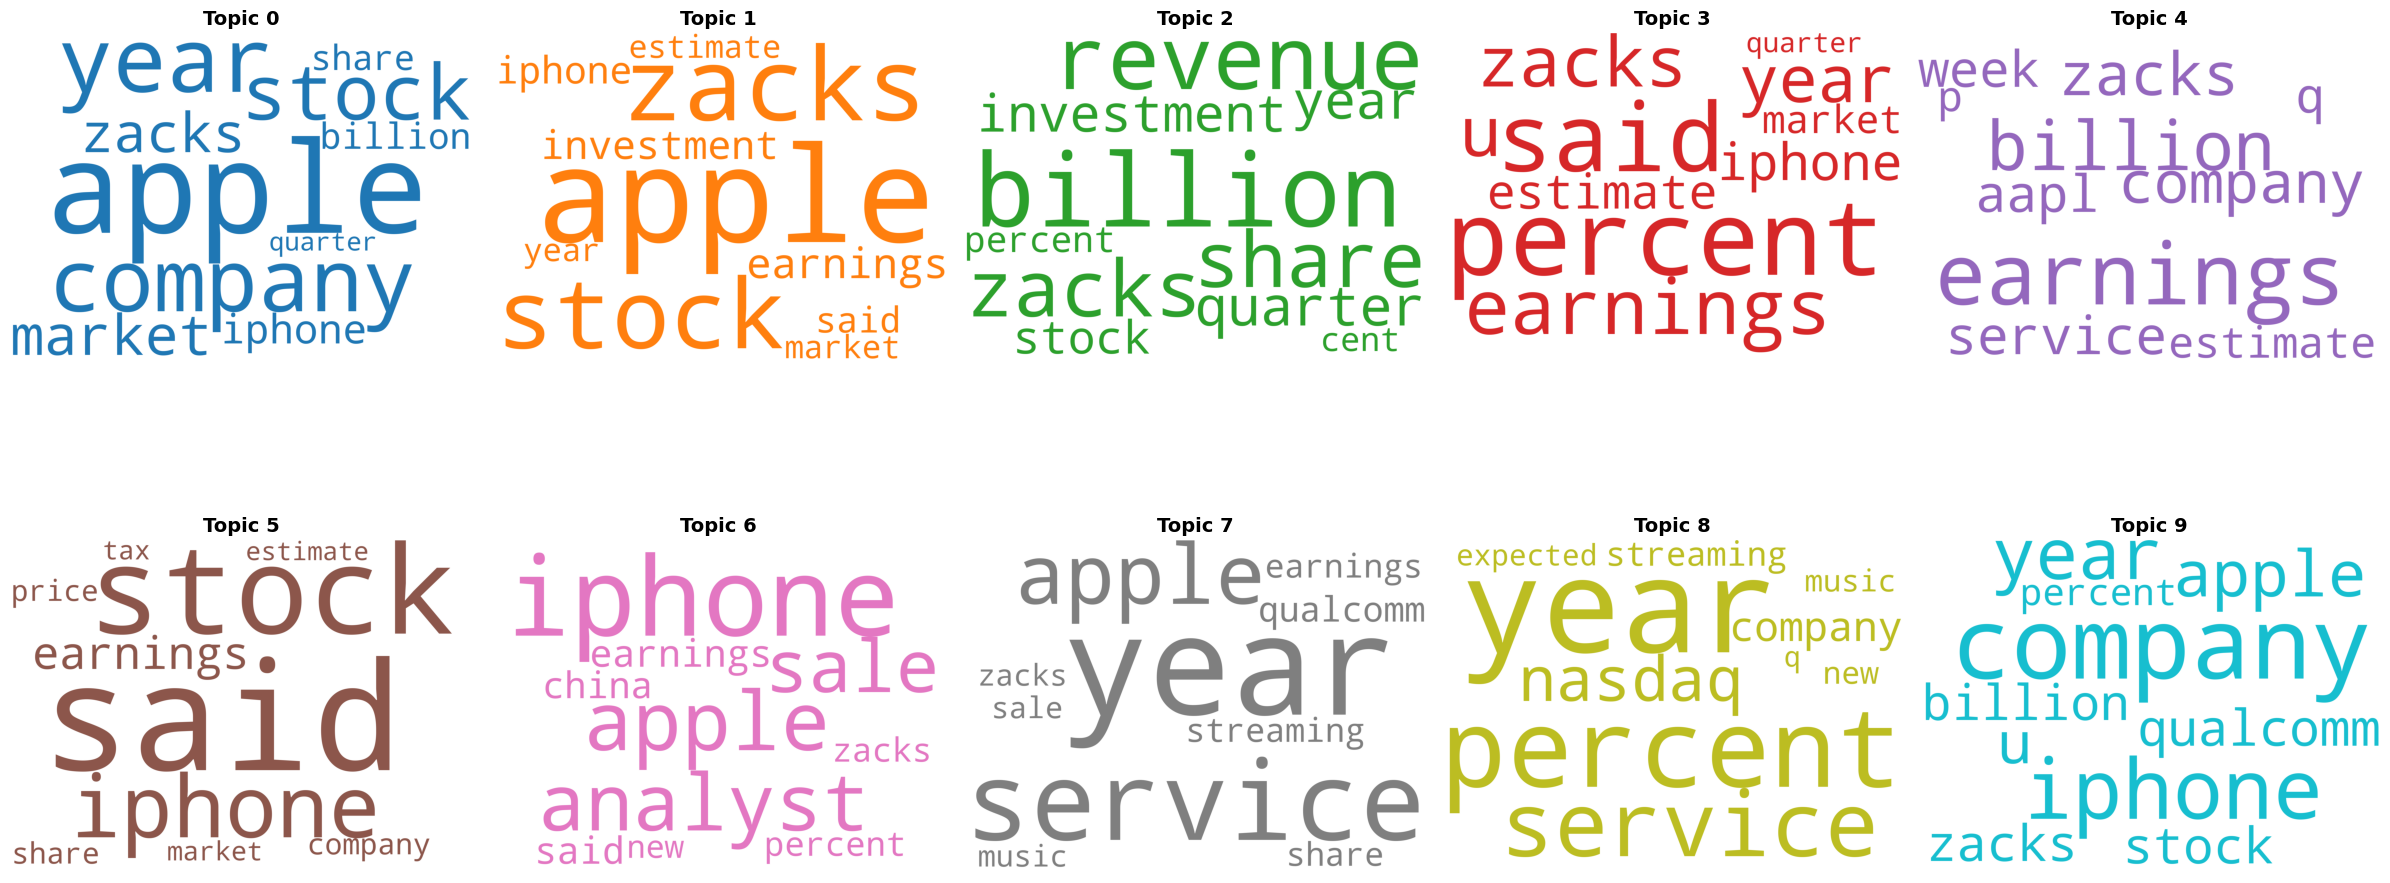

In [28]:
plot_topics(model)

### 1.6.2 LDA modeling

# 99. Scratch

In [29]:
# TODO(tomdewildt):
#  - [x] Select topic modeling algorithms
#  - [ ] How does the selected algorithm work?
#  - [ ] Run at least 5 iterations of the algorithm
#          - [ ] Create model
#          - [ ] Train model
#          - [ ] Assess quality (typo's, meaningless words, etc.)
#          - [ ] Update corpus (stopwords)
#          - [ ] Update parameters (nr of topics, vectorizer, etc.)
#  - [ ] Find optimal number of topics (based on judgment)
#  - [ ] Find optimal number of topics (based on metrics)
#  - [ ] Evaluate output (what metric, compare judgment and metric findings, etc.)
#  - [ ] Present output
#  - [ ] Limitations
#  - [ ] Applying to financial market